In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from joblib import dump

In [65]:
df = pd.read_csv('tokopedia_score_content_cleaned.csv')
df['content'] = df['content'].fillna('')

In [66]:
df['sentiment'] = df['score'].apply(lambda x: 1 if x >= 3 else 0)

In [67]:
X = df['content'].values
y = df['sentiment'].values

print(f"Total samples: {len(X)}")
print(f"Positive samples: {sum(y == 1)}")
print(f"Negative samples: {sum(y == 0)}\n")

Total samples: 5000
Positive samples: 2876
Negative samples: 2124



In [68]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

In [69]:
metrics = []
all_y_true = []
all_y_pred = []
best_params_global = None

In [70]:
for fold, (train_idx, test_idx) in enumerate(k_fold.split(X), 1):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svm', SVC())
    ])

    param_grid = {
        'svm__kernel': ['linear'],
        'svm__C': [0.1, 1, 10]
    }

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=3,
        scoring='f1',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    if fold == 1:
        best_params_global = grid.best_params_
        print(f"Best params: {best_params_global}")

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics.append([acc, prec, rec, f1])

    print(
        f"Fold {fold:2d} → "
        f"Acc: {acc:.4f}, "
        f"Prec: {prec:.4f}, "
        f"Rec: {rec:.4f}, "
        f"F1: {f1:.4f}"
    )

metrics = np.array(metrics)
mean_acc, mean_prec, mean_rec, mean_f1 = metrics.mean(axis=0)

print("\nRata-rata → "
      f"Acc: {mean_acc:.4f}, "
      f"Prec: {mean_prec:.4f}, "
      f"Rec: {mean_rec:.4f}, "
      f"F1: {mean_f1:.4f}")

Best params: {'svm__C': 1, 'svm__kernel': 'linear'}
Fold  1 → Acc: 0.8460, Prec: 0.8836, Rec: 0.8438, F1: 0.8632
Fold  2 → Acc: 0.8590, Prec: 0.9182, Rec: 0.8359, F1: 0.8751
Fold  3 → Acc: 0.8380, Prec: 0.8808, Rec: 0.8284, F1: 0.8538
Fold  4 → Acc: 0.8560, Prec: 0.8876, Rec: 0.8457, F1: 0.8662
Fold  5 → Acc: 0.8570, Prec: 0.9096, Rec: 0.8399, F1: 0.8733

Rata-rata → Acc: 0.8512, Prec: 0.8960, Rec: 0.8387, F1: 0.8663


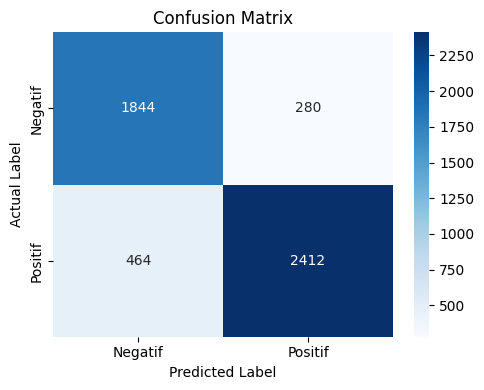

In [71]:
cm_global = confusion_matrix(all_y_true, all_y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_global,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negatif', 'Positif'],
    yticklabels=['Negatif', 'Positif']
)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(
        kernel=best_params_global['svm__kernel'],
        C=best_params_global['svm__C']
    ))
])

final_pipeline.fit(X, y)

dump(final_pipeline, 'svm_tfidf_tokopedia.pkl')

['svm_tfidf_tokopedia.pkl']